#### IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import cv2

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import cv2

# Directory containing the UTKFace dataset
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:", size)

# Initialize lists to store ages, genders, and ethnicities
ages = []
genders = []

# Loop through all files and extract ages, genders, and ethnicities
for filename in files:
    age = int(filename.split('_')[0])
    gender = int(filename.split('_')[1])
    ages.append(age)
    genders.append(gender)

# Convert lists to numpy arrays
ages = np.array(ages)
genders = np.array(genders)

# Function to load and preprocess images
def load_data(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Use the same resolution as synthetic images
            images.append(img / 255.0)  # Normalize images
            labels.append(age)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_data(path)


Total samples: 23708


#### READING THE AGES

#### READING THE IMAGES

**VISUALIZING CLASS DISTRIBUTION PRIOR TO AUGMENTATION**

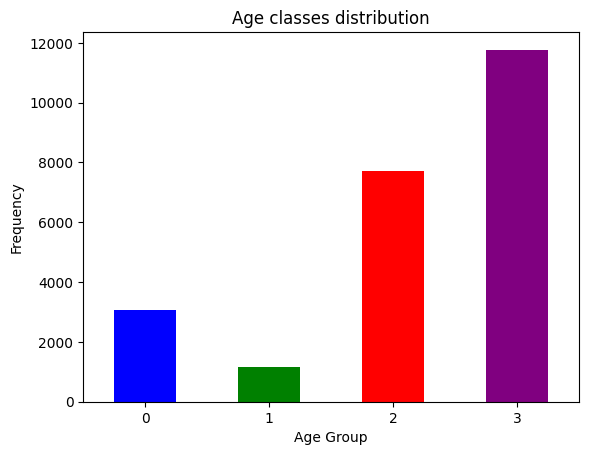

In [4]:
def age_group(age):
    if age >=0 and age < 10:
        return 0
    elif age < 18:
        return 1
    elif age < 30:
        return 2
    else:
        return 3
z=[]
for i in ages:
    z.append(i)
for i in range(0,len(z)):
    z[i]=age_group(z[i])
df = pd.DataFrame(z, columns=['Numbers'])
value_counts = df['Numbers'].value_counts().sort_index()
value_counts.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age classes distribution')
plt.xticks(ticks=[0, 1, 2, 3], labels=['0', '1', '2', '3'], rotation=0)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


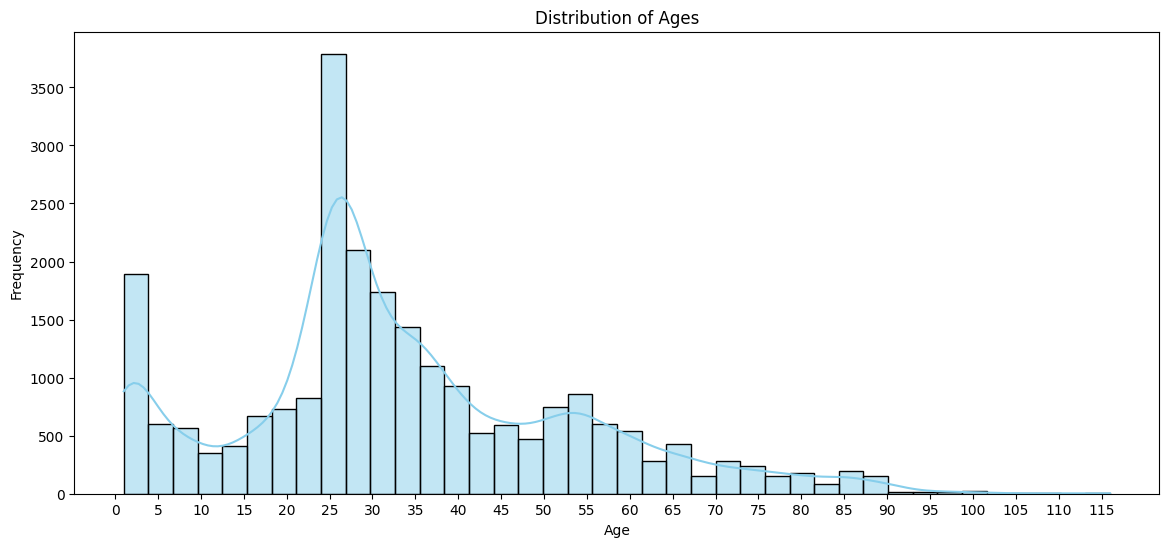

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
sns.histplot(ages, bins=40, kde=True, color='skyblue')

plt.xticks(range(0, max(ages), 5))

plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### SMOTE AUGMENTATION

In [4]:
import os
import cv2
import numpy as np
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_data(directory, age_min=12, age_max=18):
    images = []
    labels = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize images
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img.flatten())  # Flatten images to 1D
                labels.append(age)
    return np.array(images), np.array(labels)

# Directory containing the UTKFace dataset
directory = "/kaggle/input/utkface-new/UTKFace/"

# Load dataset for ages 12 to 18
images, labels = load_data(directory)

# Normalize images to [0, 1]
images = images / 255.0

# Count original images between ages 12 and 18
original_samples = len(images)

# Check if we need more samples
target_samples = 3142  # Desired number of total images between ages 12 and 18
current_samples = original_samples

if current_samples < target_samples:
    synthetic_needed = target_samples - current_samples
    smote = SMOTE(k_neighbors=5, random_state=42)
    smote_tomek=SMOTETomek(smote=smote, random_state=42)
    images_resampled, labels_resampled = smote_tomek.fit_resample(images, labels)
    
    # Only add the number of synthetic images needed
    synthetic_images = images_resampled[current_samples:current_samples + synthetic_needed]
    synthetic_images = synthetic_images.reshape(-1, 64, 64, 3)  # Reshape back to 2D
    
    # Assign random ages to synthetic images
    synthetic_ages = np.random.randint(12, 19, size=len(synthetic_images))

# Function to display original and synthetic image pair
def display_image_pair(original_images, synthetic_images):
    index = np.random.choice(len(synthetic_images))
    synthetic_image = synthetic_images[index]
    corresponding_index = find_corresponding_original(synthetic_image, original_images)
    original_image = original_images[corresponding_index].reshape(64, 64, 3)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(synthetic_image)
    plt.title("Synthetic")
    plt.axis('off')
    plt.show()

# Load dataset for ages 1 to 99
def load_data_full(directory, age_min=1, age_max=99):
    images = []
    ages = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize images
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img.flatten())  # Flatten images to 1D
                ages.append(age)
    return np.array(images), ages

# Load dataset for ages 12 to 18
images_ns, ages_ns = load_data_full(directory)
images_ns = images_ns.reshape(-1, 64, 64, 3)
ages_ns = [int(s) for s in ages_ns]

# Normalize the images
images_ns = images_ns / 255.0  # Normalize the pixel values

# Concatenate original and synthetic images and labels
combined_images = np.concatenate((images_ns, synthetic_images), axis=0)
combined_labels = np.concatenate((ages_ns, synthetic_ages), axis=0)

# Shuffle the combined dataset
shuffle_indices = np.random.permutation(len(combined_images))
combined_images = combined_images[shuffle_indices]
combined_labels = combined_labels[shuffle_indices]

# Now combined_images and combined_labels are ready for further processing or training

print(f"Total images: {len(combined_images)}")
print(f"Total labels: {len(combined_labels)}")

# Display one pair of original and synthetic images
display_image_pair(images_ns, synthetic_images)


Total images: 24272
Total labels: 24272


NameError: name 'find_corresponding_original' is not defined

In [2]:
from sklearn.metrics.pairwise import euclidean_distances

# Function to find the most similar original image to a given synthetic image
def find_corresponding_original(synthetic_image, original_images):
    synthetic_image_flat = synthetic_image.flatten().reshape(1, -1)
    original_images_flat = original_images.reshape(len(original_images), -1)
    
    distances = euclidean_distances(synthetic_image_flat, original_images_flat)
    min_index = np.argmin(distances)
    return min_index

Total images: 24258
Total labels: 24258


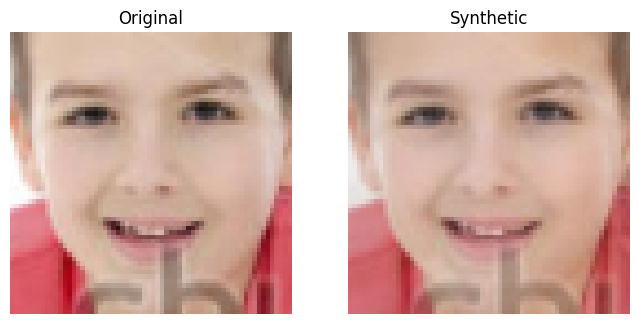

In [3]:
import os
import cv2
import numpy as np
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_data(directory, age_min=12, age_max=18):
    images = []
    labels = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize images
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img.flatten())  # Flatten images to 1D
                labels.append(age)
    return np.array(images), np.array(labels)

# Directory containing the UTKFace dataset
directory = "/kaggle/input/utkface-new/UTKFace/"

# Load dataset for ages 12 to 18
images, labels = load_data(directory)

# Normalize images to [0, 1]
images = images / 255.0

# Count original images between ages 12 and 18
original_samples = len(images)

# Check if we need more samples
target_samples = 3142  # Desired number of total images between ages 12 and 18
current_samples = original_samples

if current_samples < target_samples:
    synthetic_needed = target_samples - current_samples
    smote = SMOTE(k_neighbors=60, random_state=42)  # Set number of neighbors here
    smote_tomek = SMOTETomek(smote=smote, random_state=42)
    images_resampled, labels_resampled = smote_tomek.fit_resample(images, labels)
    
    # Only add the number of synthetic images needed
    synthetic_images = images_resampled[current_samples:current_samples + synthetic_needed]
    synthetic_images = synthetic_images.reshape(-1, 64, 64, 3)  # Reshape back to 2D
    
    # Assign random ages to synthetic images
    synthetic_ages = np.random.randint(12, 19, size=len(synthetic_images))

# Function to display original and synthetic image pair
def display_image_pair(original_images, synthetic_images):
    index = np.random.choice(len(synthetic_images))
    synthetic_image = synthetic_images[index]
    corresponding_index = find_corresponding_original(synthetic_image, original_images)
    original_image = original_images[corresponding_index].reshape(64, 64, 3)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(synthetic_image)
    plt.title("Synthetic")
    plt.axis('off')
    plt.show()

# Load dataset for ages 1 to 99
def load_data_full(directory, age_min=1, age_max=99):
    images = []
    ages = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize images
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img.flatten())  # Flatten images to 1D
                ages.append(age)
    return np.array(images), ages

# Load dataset for ages 12 to 18
images_ns, ages_ns = load_data_full(directory)
images_ns = images_ns.reshape(-1, 64, 64, 3)
ages_ns = [int(s) for s in ages_ns]

# Normalize the images
images_ns = images_ns / 255.0  # Normalize the pixel values

# Concatenate original and synthetic images and labels
combined_images = np.concatenate((images_ns, synthetic_images), axis=0)
combined_labels = np.concatenate((ages_ns, synthetic_ages), axis=0)

# Shuffle the combined dataset
shuffle_indices = np.random.permutation(len(combined_images))
combined_images = combined_images[shuffle_indices]
combined_labels = combined_labels[shuffle_indices]

# Now combined_images and combined_labels are ready for further processing or training

print(f"Total images: {len(combined_images)}")
print(f"Total labels: {len(combined_labels)}")

# Display one pair of original and synthetic images
display_image_pair(images_ns, synthetic_images)


### AUTOENCODERS AUGMENTATION DO NOT RUN

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from skimage.metrics import structural_similarity as ssim

# Load and preprocess images
def load_data_class1(directory, age_min=12, age_max=18):
    images = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Use higher resolution images
                images.append(img / 255.0)  # Normalize images
    return np.array(images)

# Directory containing the UTKFace dataset
directory = "/kaggle/input/utkface-new/UTKFace/"

# Load dataset for ages 12 to 18
imagesclass1 = load_data_class1(directory)

# Split the data into training and testing sets
train_images = imagesclass1[:int(len(imagesclass1) * 0.8)]
test_images = imagesclass1[int(len(imagesclass1) * 0.8):]

# Build the autoencoder
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(train_images, train_images,
                epochs=10,  # Train for more epochs
                batch_size=64,  # Use a smaller batch size
                shuffle=True,
                validation_data=(test_images, test_images))

# Encode and then decode the test images to generate synthetic images
decoded_imgs = autoencoder.predict(test_images)
if decoded_imgs.shape[-1] == 1:
    decoded_imgs_rgb = np.concatenate([decoded_imgs] * 3, axis=-1)
else:
    decoded_imgs_rgb = decoded_imgs


2024-05-30 09:29:51.866176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 09:29:51.866455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 09:29:52.108925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/10
 3/16 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - loss: 0.6900

KeyboardInterrupt: 

#### GENERATING AGES FOR THE SYNTHETIC IMAGES 

In [ ]:
synthetic_ages = np.random.randint(12, 18, size=len(decoded_imgs_rgb))

In [ ]:
len(synthetic_ages)==len(decoded_imgs_rgb)

In [ ]:
len(decoded_imgs_rgb)

In [ ]:
for i in synthetic_ages:
    ages.append(i)

### FIND THE MOST SIMILAR IMAGE TO THE ONE GENERATED

In [ ]:
def find_most_similar(original_images, synthetic_image):
    max_ssim = -1
    most_similar_index = -1
    for i, img in enumerate(original_images):
        s = ssim(img, synthetic_image, multichannel=True, win_size=7, channel_axis=2, data_range=1.0)
        if s > max_ssim:
            max_ssim = s
            most_similar_index = i
    return most_similar_index

# Function to display original and synthetic images
def display_image_pair(original_image, synthetic_image):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(synthetic_image)
    plt.title("Synthetic")
    plt.axis('off')
    plt.show()

# Select a random index from the test set
index = np.random.randint(0, len(decoded_imgs))
synthetic_image = decoded_imgs[index]

# Find the most similar original image
most_similar_index = find_most_similar(train_images, synthetic_image)
most_similar_image = train_images[most_similar_index]

# Display the synthetic and its most similar original image
display_image_pair(most_similar_image, synthetic_image)


In [ ]:
pictures=np.vstack((images, decoded_imgs_rgb))

In [ ]:
len(pictures)==len(ages)

### DISTRIBUTION OF AGES AND CLASSES AFTER VAE AUGMENTATION

In [ ]:
plt.figure(figsize=(14, 6))
sns.histplot(ages, bins=40, kde=True, color='skyblue')

plt.xticks(range(0, max(ages), 5))

plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
z=[]
for i in ages:
    z.append(i)
for i in range(0,len(z)):
    z[i]=age_group(z[i])

In [ ]:
df = pd.DataFrame(z, columns=['Numbers'])
value_counts = df['Numbers'].value_counts().sort_index()

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart
value_counts.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('AFTER SMOTE')
plt.xticks(ticks=[0, 1, 2, 3], labels=['0 (<10)', '1(>10 and <18)', '2(>18 and <30)', '3(>30)'], rotation=0)
plt.show()

### IMAGE PREPROCESSING

In [34]:
import numpy as np

# Convert the flattened grayscale images to the model's expected input shape (64, 64, 3)
X_data = []
for image in combined_images:
        X_data.append(image)
X_data = np.array(X_data)
X = X_data / 255.0  # Normalize the pixel values

In [36]:
target = np.array([age_group(int(age)) for age in combined_labels]).reshape(-1, 1)

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

## CUSTOMIZED CNN 

MODEL WITH SMOTE DATA AUGMENTATION 

In [38]:
import tensorflow as tf

# Define the CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_valid, y_valid))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step - accuracy: 0.4705 - loss: 1.1947 - val_accuracy: 0.4874 - val_loss: 1.1433
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.4990 - loss: 1.1085 - val_accuracy: 0.5966 - val_loss: 0.9112
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.6156 - loss: 0.9004 - val_accuracy: 0.6411 - val_loss: 0.8346
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.6412 - loss: 0.8324 - val_accuracy: 0.6498 - val_loss: 0.8067
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.6528 - loss: 0.8063 - val_accuracy: 0.6646 - val_loss: 0.7802
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.6645 - loss: 0.7772 - val_accuracy: 0.6588 - val_loss: 0.7614
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.6704 - loss: 0.7658 - val_accuracy: 0.6704 - val_loss: 0.7607
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.6703 - loss: 0

## EFFICIENT NET DO NOT RUN

In [ ]:
#x_train=x_train*255.0
#x_valid=x_valid*255.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define input image size
input_shape = (64, 64, 3)

# Define input tensor
inputs = Input(shape=input_shape)

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom top layers
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)
top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
prediction = Dense(units=4, activation='softmax', name='age_output')(x)

# Create the model
model = Model(inputs=inputs, outputs=prediction, name="EfficientNet")

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='weights.best.keras', monitor='val_accuracy', save_best_only=True)
callbacks_list = [early_stopping_callback, checkpoint]

# Train the model with increased epochs
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks_list,
    verbose=1  # Default value, shows progress per epoch
)

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
binary_predictions = np.where(predicted_classes < 2, 0, 1)  # Classify as minor/adult based on predicted age group
binary_labels = np.where(y_test.flatten() < 2, 0, 1)

# Evaluate the performance
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(binary_labels, binary_predictions))
print("Binary Classification Accuracy:", accuracy_score(binary_labels, binary_predictions))

## VGG16 DO NOT RUN

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Define input image size
input_shape = (64, 64, 3)

# Load the VGG16 model, without the top layers
vgg = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# Prevent training already trained layers
for layer in vgg.layers:
    layer.trainable = False

# Add new layers for the specific task
x = Flatten()(vgg.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the model object
model = Model(inputs=vgg.input, outputs=predictions)

# Print the model summary
model.summary()

# Create an instance of the Early Stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Checkpoint to save the best model
filepath = "weights.best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Callbacks
callbacks_list = [early_stopping_callback, checkpoint]

# Compile the model and specify loss function, optimizer, and metrics
model.compile(
    loss='sparse_categorical_crossentropy',  # Using sparse_categorical_crossentropy as your labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# Assuming x_train, y_train, x_valid, y_valid are already defined
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=64,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks_list
)



## MOBILENET

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Define input image size
input_shape = (64, 64, 3)

# Load the MobileNetV2 model, without the top layers
base_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

# Prevent training already trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for the specific task
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the model object
modelMOBILE = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
#modelMob.summary()

# Create an instance of the Early Stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Checkpoint to save the best model
filepath = "weights.best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Callbacks
callbacks_list = [early_stopping_callback, checkpoint]

# Compile the model and specify loss function, optimizer, and metrics
modelMOBILE.compile(
    loss='sparse_categorical_crossentropy',  # Using sparse_categorical_crossentropy as your labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# Assuming x_train, y_train, x_valid, y_valid are already defined
historyMOBILE = modelMOBILE.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_valid, y_valid),
    callbacks=callbacks_list
)


## PLOT OF THE LOSS/ACCURACY FOR CUSTOM CNN AND MOBILENET 

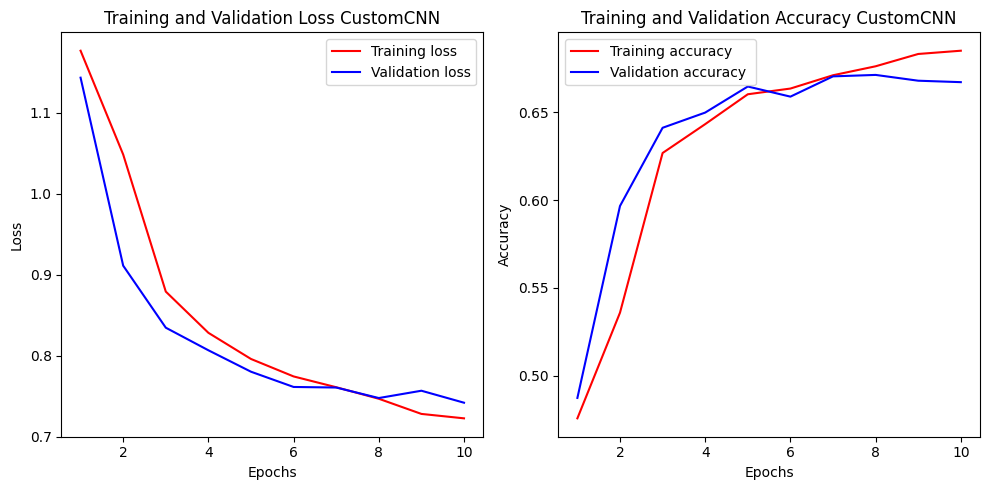

In [39]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss CustomCNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy ')
plt.title('Training and Validation Accuracy CustomCNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

train_loss = historyMOBILE.history['loss']
val_loss = historyMOBILE.history['val_loss']
train_accuracy = historyMOBILE.history['accuracy']
val_accuracy = historyMOBILE.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## EVALUATING BINARY PREDICTIONS FOR CUSTOM CNN AND MOBILENET

In [40]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1) 
binary_predictions = np.where(predicted_classes < 2, 0, 1) #I am using the predicted class to classify the person as a minor/adult 
binary_labels = np.where(y_test.flatten() < 2, 0, 1) 

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


Binary Classification Accuracy with Custom CNN on UTKFace Dataset: 91.52%
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       475
           1       0.91      0.99      0.95      1953

    accuracy                           0.92      2428
   macro avg       0.93      0.79      0.84      2428
weighted avg       0.92      0.92      0.91      2428



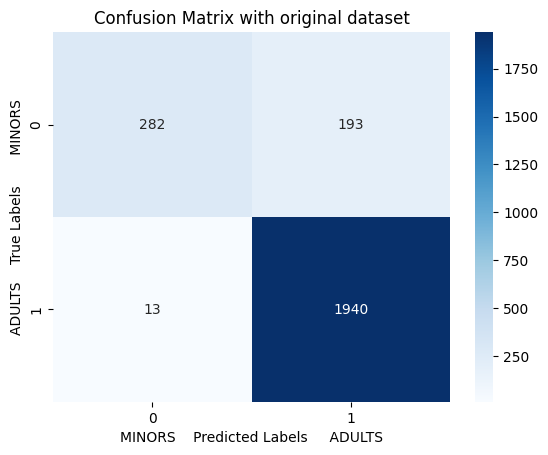

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the accuracy of the binary predictions
accuracy = accuracy_score(binary_labels, binary_predictions) #I am measuring the accuracy between the predictions and the y_test, both transformed as binary vectors of 0 if the predicted age is <18 and 1 if>18
print("Binary Classification Accuracy with Custom CNN on UTKFace Dataset: {:.2f}%".format(accuracy * 100))

# Display the classification report
print(classification_report(binary_labels, binary_predictions))

# Confusion matrix
cm = confusion_matrix(binary_labels, binary_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('MINORS    Predicted Labels     ADULTS')
plt.ylabel('ADULTS    True Labels       MINORS')
plt.title('Confusion Matrix with original dataset')
plt.show()

In [ ]:
predictionsm = modelMOBILE.predict(x_test)
predicted_classesm = np.argmax(predictionsm, axis=1) 
binary_predictionsm = np.where(predicted_classesm < 2, 0, 1) #I am using the predicted class to classify the person as a minor/adult 
binary_labelsm = np.where(y_test.flatten() < 2, 0, 1) 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the accuracy of the binary predictions
accuracym = accuracy_score(binary_labelsm, binary_predictionsm) #I am measuring the accuracy between the predictions and the y_test, both transformed as binary vectors of 0 if the predicted age is <18 and 1 if>18
print("Binary Classification Accuracy with MobileNet on UTKFace Dataset: {:.2f}%".format(accuracym * 100))

# Display the classification report
print(classification_report(binary_labelsm, binary_predictionsm))

# Confusion matrix
cm = confusion_matrix(binary_labelsm, binary_predictionsm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## TESTING MOBILENET VS CUSTOM CNN ON A THIRD DATASET

### LOADING FACIAL AGE 

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def age_group(age):
    if age < 10:
        return 0
    elif age < 18:
        return 1
    elif age < 30:
        return 2
    else:
        return 3

# Path to the dataset
dataset_path = '/kaggle/input/facial-age/face_age'

# Initialize empty lists to store processed images and age groups
processed_images = []
age_groups = []

# Iterate through the dataset folders and preprocess the images and ages
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        try:
            age = int(folder_name)  # Convert folder name to integer age
        except ValueError:
            continue  # Skip if the folder name is not a valid integer

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            image = cv2.imread(file_path)

            if image is not None:
                # Ensure the image has 3 channels and resize it to 64x64
                if image.ndim == 2:  # If the image is grayscale
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                elif image.shape[2] == 1:  # If the image has 1 channel
                    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                
                image = cv2.resize(image, (64, 64))
                
                # Normalize the image
                image = image / 255.0
                
                # Append the processed image and age group
                processed_images.append(image)
                age_groups.append(age_group(age))

# Convert lists to numpy arrays
processed_images = np.array(processed_images)
age_groups = np.array(age_groups)

# Ensure the shapes are consistent
processed_images = processed_images.reshape(-1, 64, 64, 3)

# Verify the shapes of the arrays
print(f"Images array shape: {processed_images.shape}")
print(f"Ages array shape: {age_groups.shape}")

### VISUALIZING THE AGE GROUPS FOR THE EXTERNAL DATASET

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each age group
age_group_counts = Counter(age_groups)

# Print the counts for each age group
for age_group, count in age_group_counts.items():
    print(f"Age Group {age_group}: {count} samples")

# Optional: Visualize the distribution of age groups
age_groups_sorted = sorted(age_group_counts.items())
age_groups_labels, age_groups_values = zip(*age_groups_sorted)

plt.bar(age_groups_labels, age_groups_values)
plt.xlabel('Age Groups')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Age Group')
plt.xticks(age_groups_labels, ['0-9', '10-17', '18-29', '30+'])
plt.show()


In [ ]:
age_groups=age_groups.reshape(-1,1)

#### EVALUATION OF THE CUSTOM CNN ON THE EXTERNAL DATASET

In [ ]:
custom_cnn_model = model
custom_cnn_eval = custom_cnn_model.evaluate(processed_images, age_groups, verbose=1)
print(f'Custom CNN Evaluation - Loss: {custom_cnn_eval[0]}, Accuracy: {custom_cnn_eval[1]}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
pred_custom_cnn = custom_cnn_model.predict(processed_images)
pred_custom_cnn_classes = np.argmax(pred_custom_cnn, axis=1)
binary_pred_custom_cnn = np.where(pred_custom_cnn_classes < 2, 0, 1)
binary_target = np.where(age_groups < 2, 0, 1)
custom_cnn_binary_accuracy = accuracy_score(binary_target, binary_pred_custom_cnn)
print("Binary Classification Accuracy with the Custom CNN on an external dataset: {:.2f}%".format(custom_cnn_binary_accuracy * 100))
print(classification_report(binary_target, binary_pred_custom_cnn))
cm = confusion_matrix(binary_target, binary_pred_custom_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('MINORS    Predicted Labels     ADULTS')
plt.ylabel('ADULTS    True Labels       MINORS')
plt.title('Confusion Matrix: CustomCNN on the external dataset')
plt.show()

#### EVALUATION OF THE MOBILENET ON THE EXTERNAL DATASET

In [ ]:
mobilenet_model = modelMOBILE
mobilenet_model_eval = mobilenet_model.evaluate(processed_images, age_groups, verbose=1)
print(f'MobileNet Evaluation - Loss: {mobilenet_model_eval[0]}, Accuracy: {mobilenet_model_eval[1]}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
pred_mobilenet = mobilenet_model.predict(processed_images)
mobilenet_classes = np.argmax(pred_mobilenet, axis=1)
binary_pred_mobilenet = np.where(mobilenet_classes < 2, 0, 1)
binary_target = np.where(age_groups < 2, 0, 1)
mobilenet_binary_accuracy = accuracy_score(binary_target, binary_pred_mobilenet)
print("Binary Classification Accuracy with the MobileNet on an external dataset: {:.2f}%".format(mobilenet_binary_accuracy * 100))
print(classification_report(binary_target, binary_pred_mobilenet))
cm = confusion_matrix(binary_target, binary_pred_mobilenet)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('MINORS    Predicted Labels     ADULTS')
plt.ylabel('ADULTS    True Labels       MINORS')
plt.title('Confusion Matrix: MobileNet on the external dataset')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select an image to visualize (e.g., the first image)
image_index =7
image = processed_images[image_index]

# Since preprocess_input scales the images, we need to undo this scaling for visualization
# MobileNet preprocess_input scales to [-1, 1], so we scale it back to [0, 1]
#image = (image + 1) / 2.0

# Display the image
plt.imshow(image)
plt.title(f'Age Group: {age_groups[image_index]}')
print(f'Age:{ages[image_index]}')
plt.axis('off')  # Turn off axis labels
plt.show()

## MODEL JUST WITH ORIGINAL DATASET TO ASSESS EFFECTIVENESS OF VAE AUGMENTATION

In [2]:
def age_group(age):
    if age >=0 and age < 10:
        return 0
    elif age < 18:
        return 1
    elif age < 30:
        return 2
    else:
        return 3

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import cv2
def load_data(directory, age_min=1, age_max=99):
    images = []
    ages = []
    for filename in os.listdir(directory):
        age = int(filename.split('_')[0])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize images
                #img = img / 255.0  # Normalize images
                images.append(img.flatten())  # Flatten images to 1D
                ages.append(age)
    return np.array(images), ages

# Directory containing the UTKFace dataset
directory = "/kaggle/input/utkface-new/UTKFace/"

# Load dataset for ages 12 to 18
images_ns, ages_ns = load_data(directory)
images_ns=images_ns.reshape(-1, 64, 64, 3)

In [4]:
ages_ns = [int(s) for s in ages_ns]
size = 23676
target = np.zeros((size, 1), dtype='float32')
for i in range(size):
    target[i, 0] = age_group(int(ages_ns[i])) / 4

In [5]:
len(ages_ns)

23676

In [6]:
len(images_ns)

23676

In [7]:
X_data = []
for image in images_ns:
        X_data.append(image)
X_data = np.array(X_data)
X_ns = X_data / 255.0  # Normalize the pixel values

In [8]:
target_ns = np.array([age_group(int(age)) for age in ages_ns]).reshape(-1, 1)

In [9]:
from sklearn.model_selection import train_test_split

x_train_ns, x_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, target_ns, test_size=0.2, random_state=42)
x_valid_ns, x_test_ns, y_valid_ns, y_test_ns = train_test_split(x_test_ns, y_test_ns, test_size=0.5, random_state=42)

In [10]:
import tensorflow as tf

# Define the CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()
history = model.fit(x_train_ns, y_train_ns, batch_size=64, epochs=10, validation_data=(x_valid_ns, y_valid_ns))

2024-06-03 08:59:15.574226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 08:59:15.574333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 08:59:15.712242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-06-03 08:59:31.701668: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7817: 5.66121, expected 4.98148
2024-06-03 08:59:31.701725: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7818: 5.06494, expected 4.38521
2024-06-03 08:59:31.701745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7864: 5.3748, expected 4.69507
2024-06-03 08:59:31.701768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7880: 5.56769, expected 4.88796
2024-06-03 08:59:31.701782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7925: 5.79356, expected 5.11382
2024-06-03 08:59:31.701794: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7936: 5.77592, expected 5.09619
2024-06-03 08:59:31.701806: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8000: 5.38155, expected 4.70182
2024-06-03 08:59:31.701820: E exter

 27/296 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4443 - loss: 1.2445

I0000 00:00:1717405174.891962      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5586 - loss: 1.0154

2024-06-03 08:59:37.393070: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4333: 4.87855, expected 4.28695
2024-06-03 08:59:37.393132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5653: 4.78536, expected 4.19376
2024-06-03 08:59:37.393152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7289: 4.76339, expected 4.1718
2024-06-03 08:59:37.393196: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15384: 5.75936, expected 5.06903
2024-06-03 08:59:37.393205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15417: 5.76116, expected 5.07082
2024-06-03 08:59:37.393214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15429: 5.64458, expected 4.95424
2024-06-03 08:59:37.393223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15445: 5.69563, expected 5.00529
2024-06-03 08:59:37.393231: E e

296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5599 - loss: 1.0127 - val_accuracy: 0.7031 - val_loss: 0.7040
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6884 - loss: 0.7300 - val_accuracy: 0.7259 - val_loss: 0.6524
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7189 - loss: 0.6514 - val_accuracy: 0.7487 - val_loss: 0.6210
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7441 - loss: 0.5932 - val_accuracy: 0.7441 - val_loss: 0.5964
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7586 - loss: 0.5722 - val_accuracy: 0.7479 - val_loss: 0.5861
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7642 - loss: 0.5479 - val_accuracy: 0.7568 - val_loss: 0.5852
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7698 - loss: 0.5233 - val_accuracy: 0.7618 - val_loss: 0.5667
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7751 - loss: 0.5095 - val_accuracy: 0.7614 - va

In [20]:
predictions_ns = model.predict(x_test_ns)
predicted_classes_ns = np.argmax(predictions_ns, axis=1) 
binary_predictions_ns = np.where(predicted_classes_ns < 2, 0, 1) #I am using the predicted class to classify the person as a minor/adult 
binary_labels_ns = np.where(y_test_ns.flatten() < 2, 0, 1) 

ValueError: Layer 'functional_2' expected 2 input(s). Received 1 instead.

Binary Classification Accuracy with SMOTE Augmentation: 96.71%
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       412
           1       0.97      0.99      0.98      1956

    accuracy                           0.97      2368
   macro avg       0.96      0.92      0.94      2368
weighted avg       0.97      0.97      0.97      2368



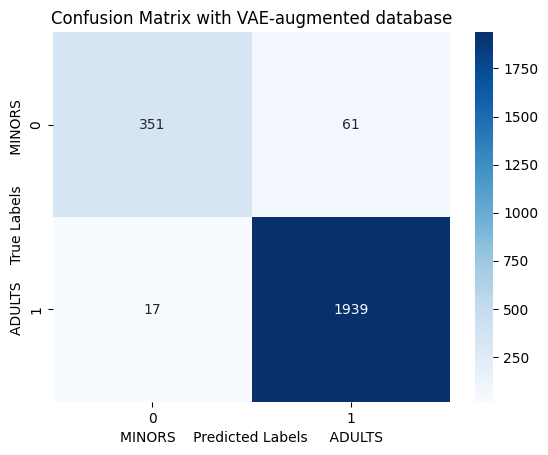

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the accuracy of the binary predictions
accuracy_ns = accuracy_score(binary_labels_ns, binary_predictions_ns) #I am measuring the accuracy between the predictions and the y_test, both transformed as binary vectors of 0 if the predicted age is <18 and 1 if>18
print("Binary Classification Accuracy with SMOTE Augmentation: {:.2f}%".format(accuracy_ns * 100))

# Display the classification report
print(classification_report(binary_labels_ns, binary_predictions_ns))

# Confusion matrix
cm = confusion_matrix(binary_labels_ns, binary_predictions_ns)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('MINORS    Predicted Labels     ADULTS')
plt.ylabel('ADULTS    True Labels       MINORS')
plt.title('Confusion Matrix with VAE-augmented database')
plt.show()

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


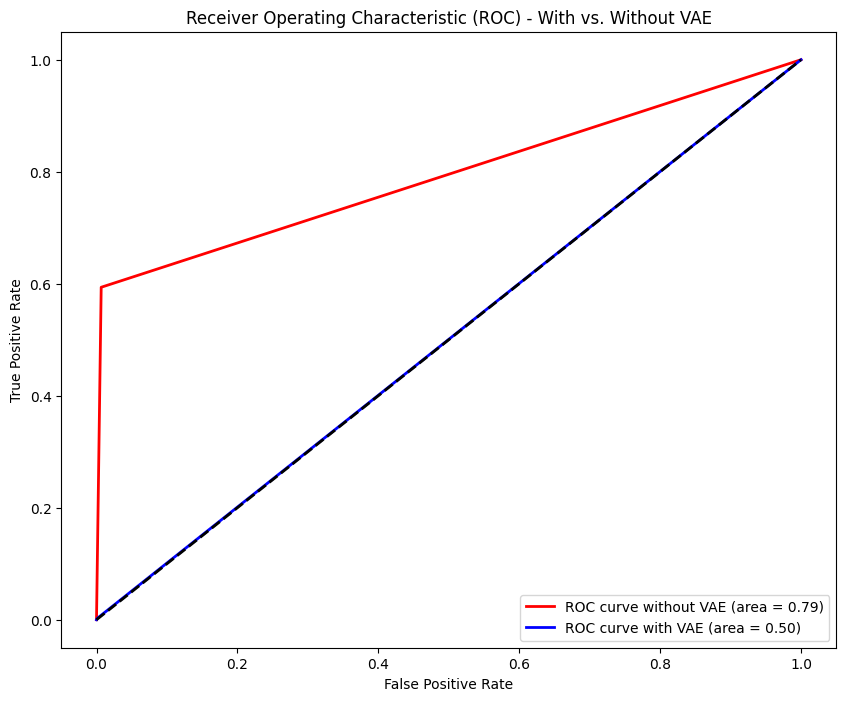

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions
predictions_smote = model.predict(x_test)
predictions_ns = model.predict(x_test_ns)

# Convert predictions to class indices
predicted_classes_smote = np.argmax(predictions_smote, axis=1)
predicted_classes_ns = np.argmax(predictions_ns, axis=1)

# Convert class indices to binary classes (minor=0, adult=1)
binary_predictions_smote = np.where(predicted_classes_smote >= 2, 0, 1)
binary_predictions_ns = np.where(predicted_classes_ns >= 2, 0, 1)

# True binary labels, already defined as binary_labels and binary_labels_ns
binary_labels = np.where(y_test.flatten() >= 2, 0, 1)
binary_labels_ns = np.where(y_test_ns.flatten() >= 2, 0, 1)

# Compute ROC curve and AUC for each set of predictions
fpr_smote, tpr_smote, _ = roc_curve(binary_labels, binary_predictions_smote)
auc_smote = auc(fpr_smote, tpr_smote)

fpr_ns, tpr_ns, _ = roc_curve(binary_labels_ns, binary_predictions_ns)
auc_ns = auc(fpr_ns, tpr_ns)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_smote, tpr_smote, label=f'ROC curve without VAE (area = {auc_smote:.2f})', color='red', linewidth=2)
plt.plot(fpr_ns, tpr_ns, label=f'ROC curve with VAE (area = {auc_ns:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - With vs. Without VAE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score

def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, ci=95):
    bootstrapped_scores = []
    rng = np.random.RandomState(seed=42)  # Control reproducibility
    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement on the indices of the data
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # Prevent cases where one class is absent in the sample
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    # Computing the lower and upper bound of the confidence interval
    lower = np.percentile(sorted_scores, (100 - ci) / 2)
    upper = np.percentile(sorted_scores, 100 - (100 - ci) / 2)
    return lower, upper

# Compute confidence intervals for the AUC
auc_ci_smote = bootstrap_auc(binary_labels, binary_predictions_smote)
auc_ci_ns = bootstrap_auc(binary_labels_ns, binary_predictions_ns)

print(f"AUC for Non-VAE: {auc_smote:.2f} with 95% CI: {auc_ci_smote}")
print(f"AUC for VAE: {auc_ns:.2f} with 95% CI: {auc_ci_ns}")


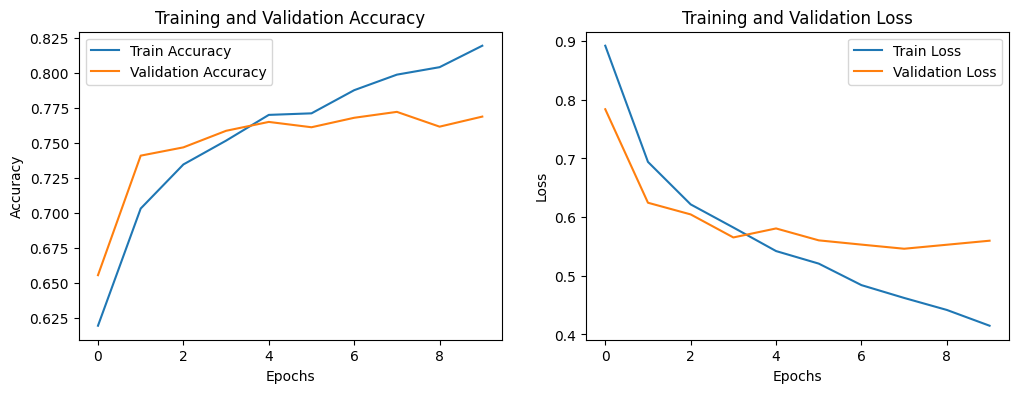

In [23]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

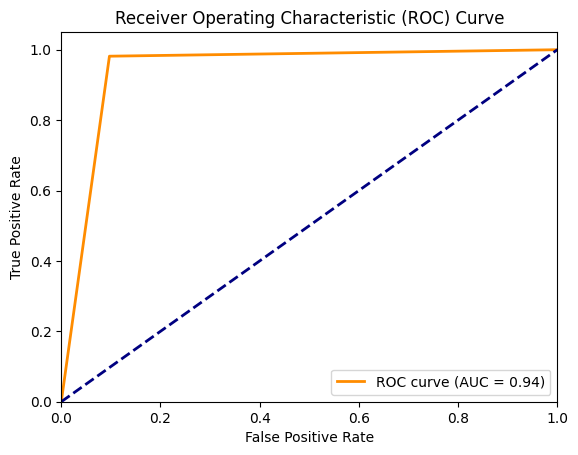

In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(binary_labels_ns, binary_predictions_ns)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

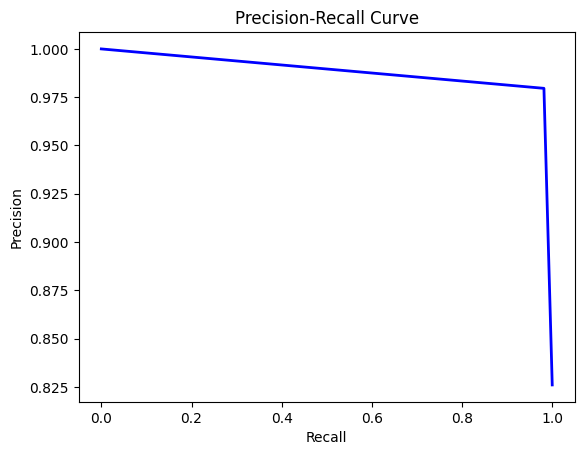

In [27]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(binary_labels_ns, binary_predictions_ns)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

TypeError: Invalid shape (12290,) for image data

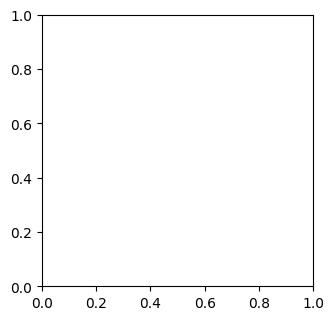

In [26]:
# Mapping for labels
label_mapping = {0: 'Minor', 1: 'Adult'}

# Display some misclassified images
misclassified_indices = np.where(binary_labels_ns != binary_predictions_ns)[0]

plt.figure(figsize=(12, 12))
for i, index in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_test_ns[index])
    true_label = label_mapping[binary_labels_ns[index]]
    pred_label = label_mapping[binary_predictions_ns[index]]
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [60]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

# Function to compute the AUC for a given set of predictions and true labels
def compute_auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

# Function to perform bootstrapping
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, ci=95):
    bootstrapped_aucs = []
    rng = np.random.RandomState(seed=42)
    
    for i in range(n_bootstraps):
        # Resample with replacement
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # If resampled data doesn't have both classes, skip this iteration
            continue
        
        auc = compute_auc(y_true[indices], y_pred[indices])
        bootstrapped_aucs.append(auc)
    
    # Calculate lower and upper bounds of the confidence interval
    sorted_aucs = np.sort(bootstrapped_aucs)
    lower_bound = np.percentile(sorted_aucs, (100 - ci) / 2)
    upper_bound = np.percentile(sorted_aucs, 100 - (100 - ci) / 2)
    
    return lower_bound, upper_bound, np.mean(sorted_aucs)

# Example usage with your test data
# Assuming binary_labels_ns are the true labels and binary_predictions_ns are the predicted probabilities
y_true = binary_labels_ns
y_pred = binary_predictions_ns  # Use probabilities if available, otherwise use binary predictions

# Perform bootstrapping
lower, upper, mean_auc = bootstrap_auc(y_true, y_pred, n_bootstraps=1000, ci=95)

print(f"Mean AUC: {mean_auc:.3f}")
print(f"95% Confidence interval for AUC: [{lower:.3f}, {upper:.3f}]")


Mean AUC: 0.932
95% Confidence interval for AUC: [0.915, 0.948]


In [19]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

def age_group(age):
    if age >= 0 and age < 10:
        return 0
    elif age < 18:
        return 1
    elif age < 30:
        return 2
    else:
        return 3

def load_data(directory, age_min=1, age_max=99):
    images = []
    ages = []
    genders = []
    for filename in os.listdir(directory):
        parts = filename.split('_')
        age = int(parts[0])
        gender = int(parts[1])
        if age_min <= age <= age_max:
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))  # Resize images
                images.append(img)  # Keep images as 3D arrays
                ages.append(age)
                genders.append(gender)
    return np.array(images), ages, genders

# Directory containing the UTKFace dataset
directory = "/kaggle/input/utkface-new/UTKFace/"

# Load dataset for ages 12 to 18
images_ns, ages_ns, genders_ns = load_data(directory)
ages_ns = [int(age) for age in ages_ns]

# Process images
images_ns = images_ns / 255.0  # Normalize the pixel values

# Process ages
target_ns = np.array([age_group(int(age)) for age in ages_ns]).reshape(-1, 1)

# One-hot encode genders
genders_ns = np.array(genders_ns)
genders_ns = tf.keras.utils.to_categorical(genders_ns, num_classes=2)

# Combine image and gender data
X_ns = [np.concatenate((img.flatten(), gender)) for img, gender in zip(images_ns, genders_ns)]
X_ns = np.array(X_ns)

# Split the data into training, validation, and test sets
x_train_ns, x_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, target_ns, test_size=0.2, random_state=42)
x_valid_ns, x_test_ns, y_valid_ns, y_test_ns = train_test_split(x_test_ns, y_test_ns, test_size=0.5, random_state=42)

# Reshape the image data back to 4D (since it was flattened for concatenation)
input_shape = (64, 64, 3)
x_train_images = x_train_ns[:, :np.prod(input_shape)].reshape(-1, *input_shape)
x_valid_images = x_valid_ns[:, :np.prod(input_shape)].reshape(-1, *input_shape)
x_test_images = x_test_ns[:, :np.prod(input_shape)].reshape(-1, *input_shape)

# Get gender data back
x_train_genders = x_train_ns[:, np.prod(input_shape):]
x_valid_genders = x_valid_ns[:, np.prod(input_shape):]
x_test_genders = x_test_ns[:, np.prod(input_shape):]

# Define the CNN architecture with gender as an additional input
image_input = tf.keras.layers.Input(shape=input_shape)
gender_input = tf.keras.layers.Input(shape=(2,))

# CNN for image data
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Concatenate image features with gender
combined = tf.keras.layers.concatenate([x, gender_input])
output = tf.keras.layers.Dense(4, activation='softmax')(combined)  # 4 classes

# Define and compile the model
model = tf.keras.Model(inputs=[image_input, gender_input], outputs=output)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit([x_train_images, x_train_genders], y_train_ns, batch_size=64, epochs=10, validation_data=([x_valid_images, x_valid_genders], y_valid_ns))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 31, 31,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 6, 6, 128) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    589,952 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 130)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        524 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 683,724 (2.61 MB)

 Trainable params: 683,724 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5533 - loss: 1.0332 - val_accuracy: 0.6554 - val_loss: 0.7839
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6967 - loss: 0.7138 - val_accuracy: 0.7407 - val_loss: 0.6245
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7335 - loss: 0.6232 - val_accuracy: 0.7466 - val_loss: 0.6046
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7523 - loss: 0.5906 - val_accuracy: 0.7584 - val_loss: 0.5653
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7712 - loss: 0.5419 - val_accuracy: 0.7648 - val_loss: 0.5807
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7688 - loss: 0.5204 - val_accuracy: 0.7610 - val_loss: 0.5604
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7882 - loss: 0.4775 - val_accuracy: 0.7677 - val_loss: 0.5531
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7999 - loss: 0.4614 - val_accuracy: 0

In [21]:
x_test_images = x_test_ns[:, :np.prod(input_shape)].reshape(-1, *input_shape)
x_test_genders = x_test_ns[:, np.prod(input_shape):]

# Predict using the model
predictions_ns = model.predict([x_test_images, x_test_genders])

# Get the predicted age group classes
predicted_classes_ns = np.argmax(predictions_ns, axis=1)

# Convert the predicted classes to binary predictions (0: minor, 1: adult)
binary_predictions_ns = np.where(predicted_classes_ns < 2, 0, 1)

# Convert the true age group labels to binary labels (0: minor, 1: adult)
binary_labels_ns = np.where(y_test_ns.flatten() < 2, 0, 1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Binary Classification Accuracy with SMOTE Augmentation: 96.79%
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       412
           1       0.98      0.98      0.98      1956

    accuracy                           0.97      2368
   macro avg       0.95      0.94      0.94      2368
weighted avg       0.97      0.97      0.97      2368



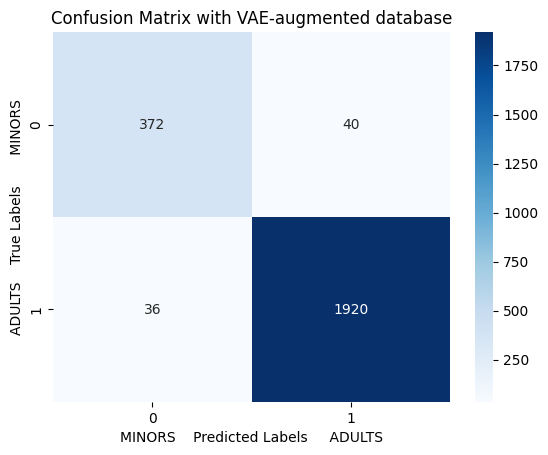

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the accuracy of the binary predictions
accuracy_ns = accuracy_score(binary_labels_ns, binary_predictions_ns) #I am measuring the accuracy between the predictions and the y_test, both transformed as binary vectors of 0 if the predicted age is <18 and 1 if>18
print("Binary Classification Accuracy with SMOTE Augmentation: {:.2f}%".format(accuracy_ns * 100))

# Display the classification report
print(classification_report(binary_labels_ns, binary_predictions_ns))

# Confusion matrix
cm = confusion_matrix(binary_labels_ns, binary_predictions_ns)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('MINORS    Predicted Labels     ADULTS')
plt.ylabel('ADULTS    True Labels       MINORS')
plt.title('Confusion Matrix with VAE-augmented database')
plt.show()